In [ ]:
['Bosphorus_1920x1080_120fps_420_8bit_YUV.yuv',
 'HoneyBee_1920x1080_120fps_420_8bit_YUV.yuv',
 'ShakeNDry_1920x1080_120fps_420_8bit_YUV.yuv',
 'CityAlley_1920x1080_50fps_420_10bit_YUV.yuv',
 'Jockey_1920x1080_120fps_420_8bit_YUV.yuv',
 'ReadySteadyGo_1920x1080_120fps_420_8bit_YUV.yuv',
 'YachtRide_1920x1080_120fps_420_8bit_YUV.yuv']


In [28]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import flowiz as fz
import cv2
import struct
from collections import Counter


# Measure file sizes
def get_size_kb(path):
    return os.path.getsize(path) / 1024.0

def load_flo_file(file_path):
    with open(file_path, 'rb') as f:
        magic = f.read(4)
        if magic != b'PIEH':
            raise Exception('Invalid .flo file')

        width = struct.unpack('i', f.read(4))[0]
        height = struct.unpack('i', f.read(4))[0]

        # Read in dx and dy (float32)
        data = np.fromfile(f, np.float32, count=2 * width * height)
        flow = np.resize(data, (height, width, 2))
        return flow


def flow_to_color(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[..., 0], flow[..., 1]
    mag, ang = cv2.cartToPolar(fx, fy)
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Hue = direction
    hsv[..., 1] = 255                    # Saturation = fixed
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Value = magnitude
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


# --- Block motion methods ---
def compute_block_vector(block, method='mean'):
    flat = block.reshape(-1, 2)
    if method == 'mean':
        return flat.mean(axis=0)
    elif method == 'median':
        return np.median(flat, axis=0)
    elif method == 'mode':
        quantized = (flat * 10).astype(int)
        tupled = [tuple(v) for v in quantized]
        most_common = Counter(tupled).most_common(1)[0][0]
        return np.array(most_common) / 10.0
    elif method == 'weighted':
        mag = np.linalg.norm(flat, axis=1)
        return (flat * mag[:, None]).sum(0) / (mag.sum() + 1e-6)
    else:
        raise ValueError(f"Unknown method: {method}")

# --- Reconstruct coarse flow from blocks ---
def reconstruct_flow(flow, grid_size, method):
    H, W, _ = flow.shape
    out = np.zeros_like(flow)
    for i in range(0, H, grid_size):
        for j in range(0, W, grid_size):
            block = flow[i:i + grid_size, j:j + grid_size]
            v = compute_block_vector(block, method)
            out[i:i + grid_size, j:j + grid_size] = v
    return out

def write_flo_file(flow, filename):
    """
    Write optical flow to .flo file (Middlebury format).
    
    Args:
        flow (np.ndarray): Optical flow array with shape (H, W, 2)
        filename (str): Path to save the .flo file
    """
    assert flow.ndim == 3 and flow.shape[2] == 2, "Flow must have shape (H, W, 2)"
    
    with open(filename, 'wb') as f:
        # Tag: 'PIEH' in ASCII = 202021.25 in float32
        f.write(struct.pack('f', 202021.25))
        f.write(struct.pack('i', flow.shape[1]))  # width
        f.write(struct.pack('i', flow.shape[0]))  # height
        flow.astype(np.float32).tofile(f)


def load_images(image_paths):
    return [Image.open(p).convert("RGB") for p in image_paths]

def load_depth_maps(depth_paths):
    return [Image.open(p).convert("L") for p in depth_paths]

def load_flows(flow_paths, format='png'):
    flows = []
    for path in flow_paths:
        if format == 'png':
            flow_img = Image.open(path).convert("RGB")
            flows.append(flow_img)
        else:
            raise ValueError("Unsupported flow format. Use 'png' or 'flo'.")
    return flows
    

Image shape: (256, 448, 3)
Depth shape: (512, 512)
Flow shape: (256, 448, 3)


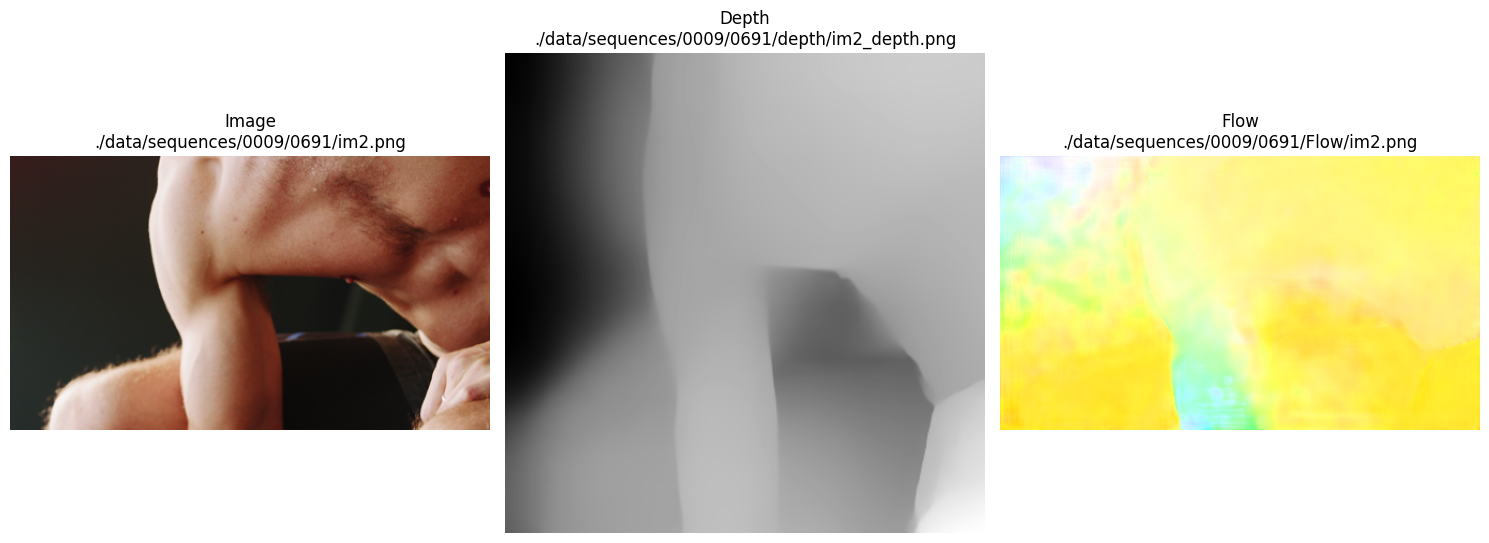

Image shape: (256, 448, 3)
Depth shape: (512, 512)
Flow shape: (256, 448, 3)


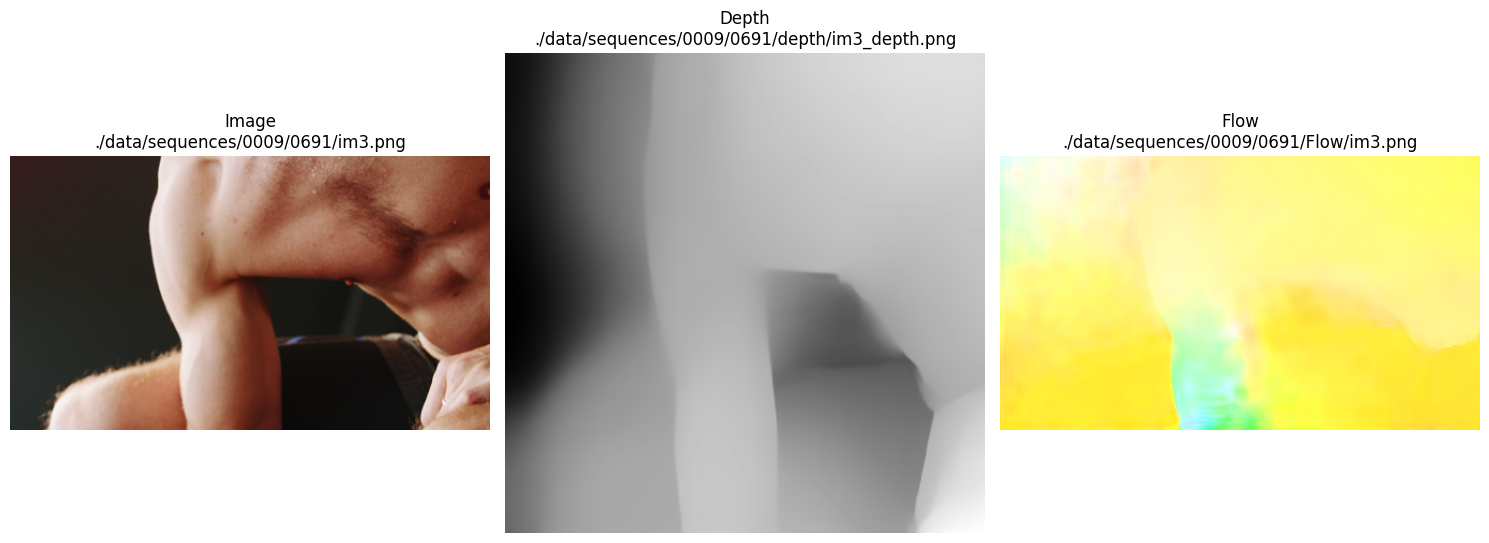

In [7]:
def get_triplet_paths(base_folder):
    image_paths = sorted([
        os.path.join(base_folder, f)
        for f in os.listdir(base_folder)
        if f.endswith(".png") and f not in {"r1.png", "r2.png"}
    ])
    # print(image_paths)
    depth_paths = [
        os.path.join(base_folder, "depth", os.path.splitext(os.path.basename(p))[0] + "_depth.png")
        for p in image_paths
    ]
    flow_paths  = [os.path.join(base_folder, "Flow", os.path.splitext(os.path.basename(p))[0] + ".png") for p in image_paths]
    return image_paths, depth_paths, flow_paths



def show_triplets(images, depths, flows, paths, max_show=5):
    for i in range(min(max_show, len(images))):
        fig, axs = plt.subplots(1, 3, figsize=(15, 10))
        axs[0].imshow(images[i])
        axs[0].set_title(f"Image\n{paths['image'][i]}")
        axs[1].imshow(depths[i], cmap='gray')
        axs[1].set_title(f"Depth\n{paths['depth'][i]}")
        axs[2].imshow(flows[i])
        axs[2].set_title(f"Flow\n{paths['flow'][i]}")

        for ax in axs:
            ax.axis("off")

        print(f"Image shape: {np.array(images[i]).shape}")
        print(f"Depth shape: {np.array(depths[i]).shape}")
        print(f"Flow shape: {np.array(flows[i]).shape}")
        print("=" * 60)
        plt.tight_layout()
        plt.show()

base_dir = "./data/sequences/0009/0691"
image_paths, depth_paths, flow_paths = get_triplet_paths(base_dir)

images = load_images(image_paths)
depths = load_depth_maps(depth_paths)
flows  = load_flows(flow_paths, format="png")  # or 'flo'
# Show a few triplets
show_triplets(images[0:2], depths[0:2], flows[0:2], {
    "image": image_paths[0:2],
    "depth": depth_paths[0:2],
    "flow": flow_paths[0:2]
})

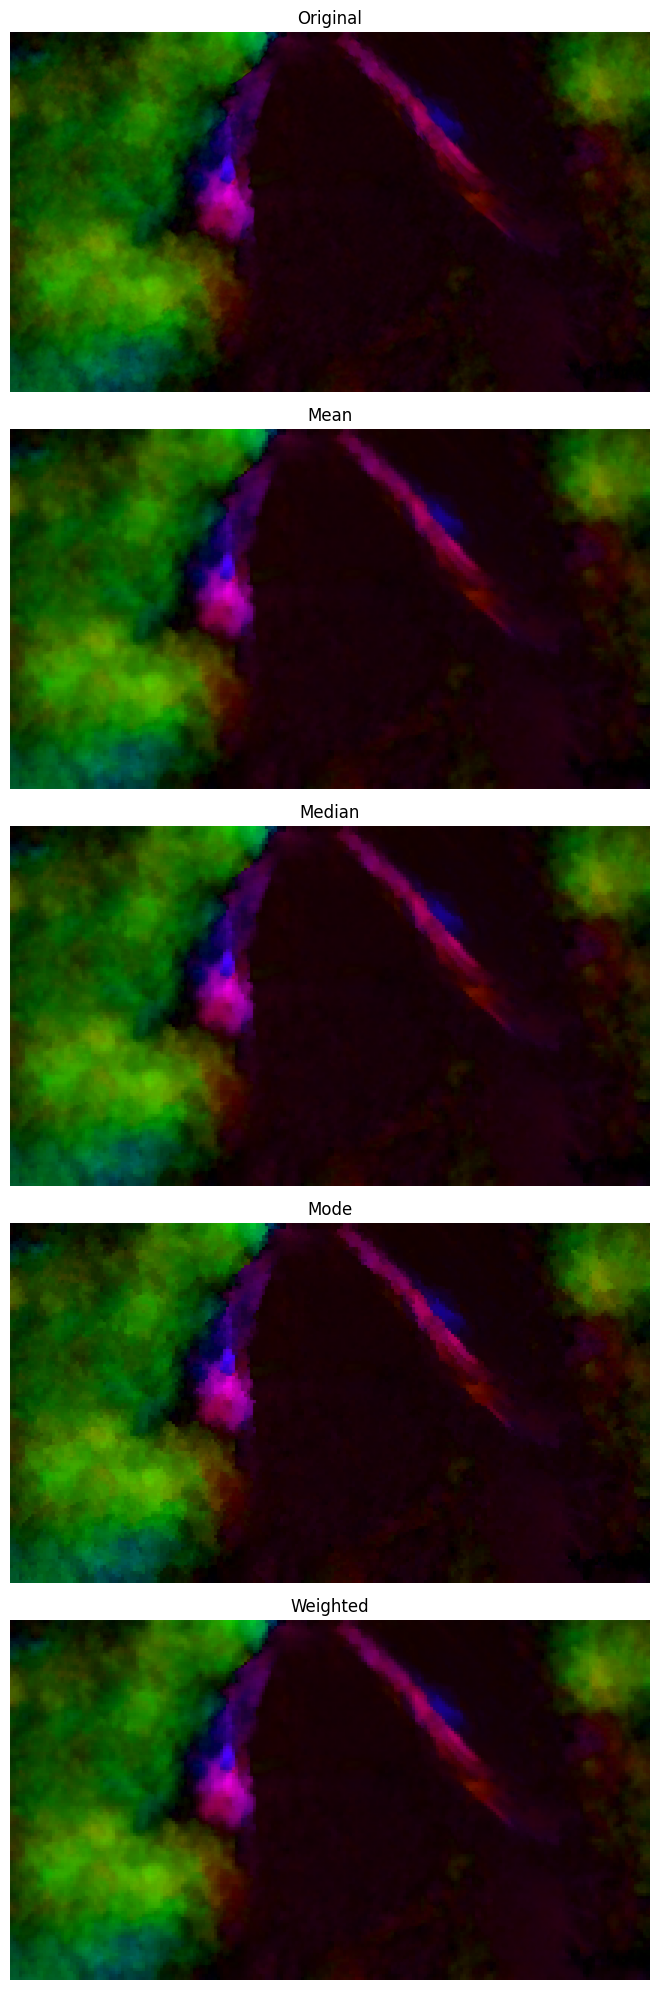

In [31]:
# --- Main ---
flow_path = "data/UVG_test_data/Beauty/1080p/optical_flow/flow_0000_0001.flo"  # change to your path
grid_size = 9
methods = ['mean', 'median', 'mode', 'weighted']

flow = load_flo_file(flow_path)
original_vis = flow_to_color(flow)
reconstructed_flows = [reconstruct_flow(flow, grid_size, m) for m in methods]
visualizations = [flow_to_color(f) for f in reconstructed_flows]

# --- Plot vertically ---
titles = ["Original"] + [m.capitalize() for m in methods]
images = [original_vis] + visualizations

plt.figure(figsize=(10, 20))
for i, (img, title) in enumerate(zip(images, titles)):
    ax = plt.subplot(len(images), 1, i + 1)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()


In [12]:
npz_path = flow_path.replace(".flo", ".npz")
np.savez_compressed(npz_path, flow=flow)
grid_paths = []
for i,recon in enumerate(reconstructed_flows):
    save_path = flow_path.replace(".flo", f"_{methods[i]}_grid.npz")
    np.savez_compressed(save_path, flow=recon)
    grid_paths.append(save_path)

original_flo_size = get_size_kb(flow_path)
npz_size = get_size_kb(npz_path)
grid_sizes = {method: get_size_kb(path) for method, path in zip(methods, grid_paths)}
(original_flo_size, npz_size, grid_sizes)

(896.01171875,
 823.3642578125,
 {'mean': 9.2421875,
  'median': 9.232421875,
  'mode': 8.2724609375,
  'weighted': 9.2353515625})

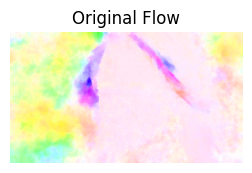

In [36]:
grid_sizes = [3, 5, 9, 12, 16]
original_flow_color = fz.convert_from_file(flow_path)
h, w = original_flow_color.shape[:2]

plt.figure(figsize=(15, 10))
plt.subplot(2, len(grid_sizes)+1, 1)
plt.imshow(original_flow_color)
plt.title("Original Flow")
plt.axis('off')

for i, grid_size in enumerate(grid_sizes):
    # Reconstruct flow with grid
    new_flow = reconstruct_flow(flow, grid_size, 'weighted')
    # Convert to color
    
    flow_img = fz.convert_from_file(flo_output_path)(new_flow)

    # Downsample
    down_h, down_w = h // grid_size, w // grid_size
    downsampled = cv2.resize(flow_img, (down_w, down_h), interpolation=cv2.INTER_AREA)

    # Save downsampled image
    save_path = f"data/downsample/flow_grid{grid_size}.png"
    cv2.imwrite(save_path, downsampled[..., ::-1])  # Convert RGB to BGR for saving

    # Upsample back to original
    upsampled = cv2.resize(downsampled, (w, h), interpolation=cv2.INTER_LINEAR)

    # Plot the upsampled result
    plt.subplot(2, len(grid_sizes)+1, i + 2)
    plt.imshow(upsampled)
    plt.title(f"Grid {grid_size}")
    plt.axis('off')

plt.tight_layout()
plt.show()

/tmp/ipykernel_2208492/4272000999.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,len(grid_names)+1, idx + 2)


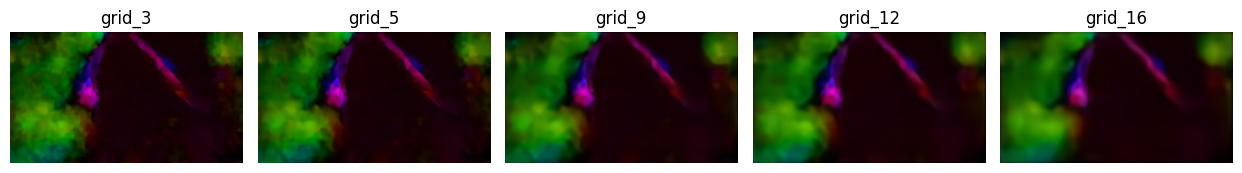

In [25]:

original_rgb = flow_to_color(flow)

decoded_folder = "data/downsample/"
grid_names = ["grid_3", "grid_5", "grid_9", "grid_12", "grid_16"]
target_size = (1920, 1080)  # width, height

plt.figure(figsize=(15, 8))
plt.subplot(2, len(grid_names), 1)
plt.imshow(original_rgb)
plt.title("Original")
plt.axis('off')

for idx, grid_name in enumerate(grid_names):
    image_path = os.path.join(decoded_folder, f"{grid_name}.png")
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    plt.subplot(2,len(grid_names)+1, idx + 2)
    plt.imshow(img_rgb)
    plt.title(grid_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [26]:
from pathlib import Path

folder = Path("data/downsample/")  # replace with your folder path

for bin_file in folder.glob("*.bin"):
    size_bytes = bin_file.stat().st_size
    print(f"{bin_file.name}: {size_bytes} bytes")


grid_5.bin: 1835 bytes
grid_9.bin: 911 bytes
frame_1080.bin: 27083 bytes
grid_3.bin: 3623 bytes
grid_12.bin: 675 bytes
grid_16.bin: 447 bytes
frame_512.bin: 4407 bytes


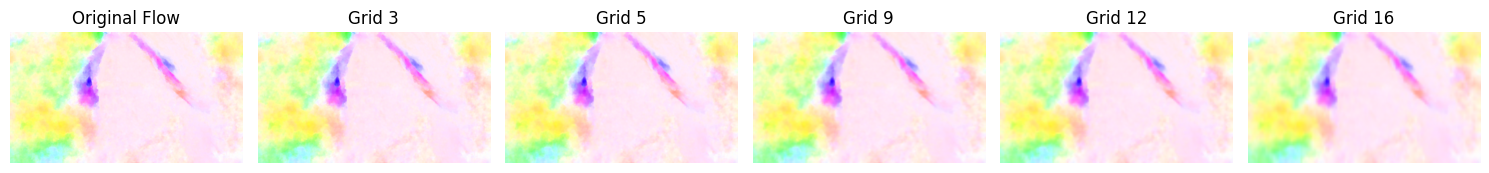

In [38]:
def write_flo_file(flow, filename):
    """
    Write optical flow to .flo file (Middlebury format).
    
    Args:
        flow (np.ndarray): Optical flow array with shape (H, W, 2)
        filename (str): Path to save the .flo file
    """
    assert flow.ndim == 3 and flow.shape[2] == 2, "Flow must have shape (H, W, 2)"
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    with open(filename, 'wb') as f:
        # Tag: 'PIEH' in ASCII = 202021.25 in float32
        f.write(struct.pack('f', 202021.25))
        f.write(struct.pack('i', flow.shape[1]))  # width
        f.write(struct.pack('i', flow.shape[0]))  # height
        flow.astype(np.float32).tofile(f)

grid_sizes = [3, 5, 9, 12, 16]
original_flow_color = fz.convert_from_file(flow_path)
h, w = original_flow_color.shape[:2]

plt.figure(figsize=(15, 10))
plt.subplot(2, len(grid_sizes)+1, 1)
plt.imshow(original_flow_color)
plt.title("Original Flow")
plt.axis('off')

for i, grid_size in enumerate(grid_sizes):
    # Reconstruct flow with grid
    new_flow = reconstruct_flow(flow, grid_size, 'weighted')
    
    # Save the new flow to a .flo file
    flo_filename = f"data/downsample/flow_grid{grid_size}.flo"
    write_flo_file(new_flow, flo_filename)
    
    # Load the saved .flo file and convert to color
    flow_img = fz.convert_from_file(flo_filename)

    # Downsample
    down_h, down_w = h // grid_size, w // grid_size
    downsampled = cv2.resize(flow_img, (down_w, down_h), interpolation=cv2.INTER_AREA)

    # Save downsampled image
    save_path = f"data/downsample/flow_grid{grid_size}.png"
    cv2.imwrite(save_path, downsampled[..., ::-1])  # Convert RGB to BGR for saving

    # Upsample back to original
    upsampled = cv2.resize(downsampled, (w, h), interpolation=cv2.INTER_LINEAR)

    # Plot the upsampled result
    plt.subplot(2, len(grid_sizes)+1, i + 2)
    plt.imshow(upsampled)
    plt.title(f"Grid {grid_size}")
    plt.axis('off')

plt.tight_layout()
plt.show()